<a href="https://colab.research.google.com/github/E-Fung/Classification_PCD/blob/main/PCD_Model_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INITIALIZE LIBRARIES AND MODEL NAMES**

In [ ]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


In [ ]:
import sklearn
sklearn.__version__

'0.24.1'

In [ ]:
#########################################################################################################################################################################
#   Initialize libraries and such
#########################################################################################################################################################################

%tensorflow_version 2.x  # this line is not required unless you are in a notebook
from __future__ import absolute_import, division, print_function, unicode_literals
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import io
import os

# Print versions
!python --versions
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

tflite_model_name = 'PCD_Model'
c_model_name = 'PCD_Model'

#This is for gathering the metrics (accuracy % loss) for another set of values
class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

#########################################################################################################################################################################

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
unknown option --versions
usage: python3 [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.
Numpy 1.19.5
TensorFlow 2.4.1
Keras 2.4.0


# **UPLOADING DATA**

In [ ]:
#########################################################################################################################################################################
#   Uploading Files
#########################################################################################################################################################################
data_arr = ['data_n01','data_n02','data_n03','data_n04','data_n05','data_n06','data_n07','data_n08']
file_name = data_arr
#Change this to the name of the csv file you are uploading
uploaded = files.upload()
#########################################################################################################################################################################

Saving data_n01.csv to data_n01.csv
Saving data_n02.csv to data_n02.csv
Saving data_n03.csv to data_n03.csv
Saving data_n04.csv to data_n04.csv
Saving data_n05.csv to data_n05.csv
Saving data_n06.csv to data_n06.csv
Saving data_n07.csv to data_n07.csv
Saving data_n08.csv to data_n08.csv


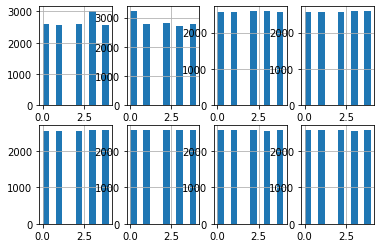

In [ ]:
#Verify that the data files are unique and have around the same data for each posture
data_arr = ['data_n01','data_n02','data_n03','data_n04','data_n05','data_n06','data_n07','data_n08']
dd1 = 'data_n01'
dd2 = 'data_n02'
dd3 = 'data_n03'
dd4 = 'data_n04'
dd5 = 'data_n05'
dd6 = 'data_n06'
dd7 = 'data_n07'
dd8 = 'data_n08'
imp_dd1 = pd.read_csv(dd1+'.csv')
imp_dd2 = pd.read_csv(dd2+'.csv')
imp_dd3 = pd.read_csv(dd3+'.csv')
imp_dd4 = pd.read_csv(dd4+'.csv')
imp_dd5 = pd.read_csv(dd5+'.csv')
imp_dd6 = pd.read_csv(dd6+'.csv')
imp_dd7 = pd.read_csv(dd7+'.csv')
imp_dd8 = pd.read_csv(dd8+'.csv')
plt.subplot(2,4,1)
imp_dd1.Class.hist()
plt.subplot(2,4,2)
imp_dd2.Class.hist()
plt.subplot(2,4,3)
imp_dd3.Class.hist()
plt.subplot(2,4,4)
imp_dd4.Class.hist()
plt.subplot(2,4,5)
imp_dd5.Class.hist()
plt.subplot(2,4,6)
imp_dd6.Class.hist()
plt.subplot(2,4,7)
imp_dd7.Class.hist()
plt.subplot(2,4,8)
imp_dd8.Class.hist()

# **DATA PROCESSING**

In [ ]:
#########################################################################################################################################################################
#   This block of code is for processing the data, made into a function to implement n-fold cross validation
#########################################################################################################################################################################

def get_data(i,Relative_IMU):

  #Change these
  train_row_increments = 5
  test_row_increments = 5

  #Initialize variables
  data_arr = ['data_n01','data_n02','data_n03','data_n04','data_n05','data_n06','data_n07','data_n08']
  test_data = data_arr[i]
  data_arr.remove(data_arr[i])
  train_data_01 = data_arr[0]
  train_data_02 = data_arr[1]
  train_data_03 = data_arr[2]
  train_data_04 = data_arr[3]
  train_data_05 = data_arr[4]
  train_data_06 = data_arr[5]
  train_data_07 = data_arr[6]
  # train_data_08 = data_arr[7]

  #Initialize dataframes for storing the data and combine them 
  train_data1 = pd.read_csv(train_data_01+'.csv')
  train_data2 = pd.read_csv(train_data_02+'.csv')
  train_data3 = pd.read_csv(train_data_03+'.csv')
  train_data4 = pd.read_csv(train_data_04+'.csv')
  train_data5 = pd.read_csv(train_data_05+'.csv')
  train_data6 = pd.read_csv(train_data_06+'.csv')
  train_data7 = pd.read_csv(train_data_07+'.csv')
  # train_data8 = pd.read_csv(train_data_08+'.csv')
  train_data_combined = pd.concat([train_data1,train_data2,train_data3,train_data4,train_data5,train_data6,train_data7],ignore_index=True)

  #Rearrange the data such that all IMUs share the "same" orientation, this allows us to try feeding relative IMU angles instead of raw IMU angles
  temp = train_data_combined['x1']
  train_data_combined['x1'] = train_data_combined['y1']*-1
  train_data_combined['y1'] = temp
  temp = train_data_combined['x2']
  train_data_combined['x2']=train_data_combined['y2']
  train_data_combined['y2']=temp

  if Relative_IMU:
    train_data_combined['x1'] = train_data_combined['x1']-train_data_combined['x3']
    train_data_combined['y1'] = train_data_combined['y1']-train_data_combined['y3']
    train_data_combined['z1'] = train_data_combined['z1']-train_data_combined['z3']
    train_data_combined['x2'] = train_data_combined['x2']-train_data_combined['x3']
    train_data_combined['y2'] = train_data_combined['y2']-train_data_combined['y3']
    train_data_combined['z2'] = train_data_combined['z2']-train_data_combined['z3']
    train_data_combined['x3'] = train_data_combined['x3']-train_data_combined['x4']
    train_data_combined['y3'] = train_data_combined['y3']-train_data_combined['y4']
    train_data_combined['z3'] = train_data_combined['z3']-train_data_combined['z4']

  #Process the data::
  train_data_sampled = train_data_combined[1::train_row_increments]#sample every few rows to improve training data (IMUs give data very frequently so the data is very similar)
  data_shuffled = train_data_sampled.sample(frac=1).reset_index(drop=True)#shuffle it
  d0 = data_shuffled.loc[data_shuffled['Class'] == 0]#split the data by their posture, the data remains ordered (post shuffle)
  d1 = data_shuffled.loc[data_shuffled['Class'] == 1]
  d2 = data_shuffled.loc[data_shuffled['Class'] == 2]
  d3 = data_shuffled.loc[data_shuffled['Class'] == 3]
  d4 = data_shuffled.loc[data_shuffled['Class'] == 4]
  min_class = min(len(d0),len(d1),len(d2),len(d3),len(d4))
  d0_split = d0.sample(frac=(min_class/len(d0)),random_state=1) #slice so that all postures have same number of data entries
  d1_split = d1.sample(frac=(min_class/len(d1)),random_state=1) 
  d2_split = d2.sample(frac=(min_class/len(d2)),random_state=1) 
  d3_split = d3.sample(frac=(min_class/len(d3)),random_state=1) 
  d4_split = d4.sample(frac=(min_class/len(d4)),random_state=1) 
  data_final_combine = pd.concat([d0_split,d1_split,d2_split,d3_split,d4_split],ignore_index=True)#combine them
  data_processed = data_final_combine.sample(frac=1).reset_index(drop=True)#shuffle again
  posture_processed = data_processed.pop('Class')
  data_processed = data_processed/180 #you want the data to be between -1 and 1, the IMU code restricts the angles between 180 and -180

  global x_val,x_train,y_val,y_train,x_val_test,y_val_test

  #Split the data into 2 sets:: Training and Validation(used to check against overfitting, you dont want training accuracy to be over validation) 
  val_ratio = 0.3    # Percentage of samples that should be held for validation set
  length_data_processed = data_processed.shape[0]
  val_split = int(val_ratio * length_data_processed)
  x_val, x_train = np.split(data_processed, [val_split])
  y_val, y_train = np.split(posture_processed, [val_split])
  assert(x_train.size + x_val.size) == data_processed.size

  #Process the data for the testing data (This will be data from a new user that has never had their data in the training set)
  x_val_test = pd.read_csv(test_data+'.csv')
  x_val_test = x_val_test[1::test_row_increments]
  x_val_test = x_val_test.sample(frac=1).reset_index(drop=True)
  y_val_test = x_val_test.pop('Class')
  x_val_test = x_val_test/ 180

  #Rearrange the data
  temp = x_val_test['x1']
  x_val_test['x1'] = x_val_test['y1']*-1
  x_val_test['y1'] = temp
  temp = x_val_test['x2']
  x_val_test['x2']=x_val_test['y2']
  x_val_test['y2']=temp

  if Relative_IMU:
    x_val_test['x1'] = x_val_test['x1']-x_val_test['x3']
    x_val_test['y1'] = x_val_test['y1']-x_val_test['y3']
    x_val_test['z1'] = x_val_test['z1']-x_val_test['z3']
    x_val_test['x2'] = x_val_test['x2']-x_val_test['x3']
    x_val_test['y2'] = x_val_test['y2']-x_val_test['y3']
    x_val_test['z2'] = x_val_test['z2']-x_val_test['z3']
    x_val_test['x3'] = x_val_test['x3']-x_val_test['x4']
    x_val_test['y3'] = x_val_test['y3']-x_val_test['y4']
    x_val_test['z3'] = x_val_test['z3']-x_val_test['z4']

#########################################################################################################################################################################

# **MODEL CREATION**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 80)                1040      
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 255       
Total params: 5,345
Trainable params: 5,345
Non-trainable params: 0
______________________________________________________

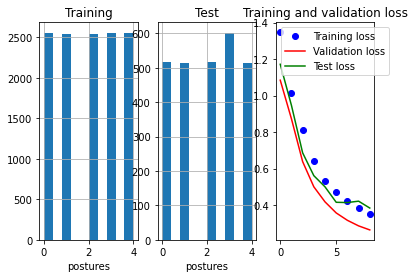

84/84 - 0s - loss: 0.3841 - accuracy: 0.8390

Test accuracy: 0.8390243649482727


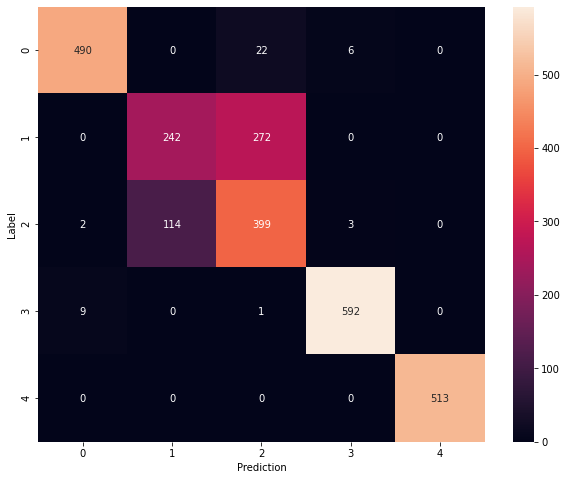

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#########################################################################################################################################################################
#   This block of code is for trying different model configurations and seeing what works best
#########################################################################################################################################################################

Save_Performance = False
Custom_Learn_Rate = False
Verbose = 2 
Visualize = True
Relative_IMU = True

#Affects the range of layers that the models will have and how much times we want to test that setup
layer_1_itr = 1       #how many different first layer sizes to try
layer_2_itr = 1       #how many different second layer sizes to try
test_per_config = 1   #how many times we want to test one model spec *(use multiple of total datasets)*

hidden_layer_1 = 80
hidden_layer_2 = 50
hidden_layer_1_interval = 5
hidden_layer_2_interval = 5

starting_num_epochs = 30

dropout_percent = 0.2
callback_patience=3
decay_rate = 0.90
decay_steps = 200

saved_metric_name = 'Model_Creation_8_DS_02' #A file under this name will be saved containing the performance of different model configurations
saved_acc_name = 'Acc_'+saved_metric_name
#########################################################################################################################################################################

#Only for telling us how much more models will be tested
curr_run = 0
total_run = layer_1_itr*layer_2_itr*test_per_config 

test_history = pd.DataFrame(columns=['Accuracy','Layer 1','Layer 2','Dropout %','Average of','Patience','IN Learning Rate','decay_rate','decay_steps','Relative_IMU'])#stores performance stats
acc_history = pd.DataFrame(columns=['Run','Accuracy','Layer 1','Layer 2','Dropout %','Average of','Patience','IN Learning Rate','decay_rate','decay_steps','Relative_IMU'])
for i in range(0,layer_1_itr):
  for j in range(0,layer_2_itr):
    average_accuracy = 0;
    for k in range(0,test_per_config):
      get_data(curr_run%8,Relative_IMU)
      if Visualize: #to verify data being passed through looks good
        plt.subplot(1,3,1)
        y_train.hist() #displays the histogram based on posture
        plt.title("Training")
        plt.xlabel('postures')
        plt.subplot(1,3,2)
        y_val_test.hist()
        plt.title("Test")
        plt.xlabel('postures')

      initial_learning_rate = (hidden_layer_1+i*hidden_layer_1_interval)/10000

      #Creates the model structure and chooses the activation function for each layer
      model = tf.keras.Sequential([                      
          tf.keras.layers.Flatten(input_shape=(12,1)),
          tf.keras.layers.Dense(hidden_layer_1+i*hidden_layer_1_interval, activation='relu', name= "Layer_1",kernel_initializer='random_normal'),  #hidden layers are generally: relu, sigmoid, tanh (Usually constant for all hidden layers)
          tf.keras.layers.Dropout(dropout_percent), #dropouts only occur during training
          tf.keras.layers.Dense(hidden_layer_2+j*hidden_layer_2_interval, activation='relu', name= "Layer_2",kernel_initializer='random_normal'),  
          tf.keras.layers.Dropout(dropout_percent),
          tf.keras.layers.Dense(5, activation='linear', name= "Predicted_Posture"), #output layers are generally: linear, sigmoid, softmax
      ])

      if Visualize:
        model.summary()

      #Stops the model training early to prevent overfitting
      callbacks = [
      tf.keras.callbacks.EarlyStopping(# Stop training when `val_loss` is no longer improving
          monitor="val_accuracy",
          # min_delta=callback_delta,
          mode='auto',
          patience=callback_patience,# "no longer improving" being further defined as "for at least x epochs"
          verbose=1,
        )
      ] 

      #Adds the x_val dataset to be tested 
      val_test = AdditionalValidationSets([(x_val, y_val, 'val2')])

      #Saves the models when the accuracy is pred_post based on the test values
      temp_str = str(curr_run+1)
      while len(temp_str) < len(str(total_run)):
        temp_str = str(0)+temp_str 
      checkpoint_path = "training_"+temp_str+"/cp.ckpt"
      checkpoint_dir = os.path.dirname(checkpoint_path)
      cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor="val_accuracy",mode= "auto",save_best_only=True,save_weights_only=True,verbose=Verbose)

      #Assign type of: optimizer, loss, and metric
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
      model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

      #Print out which loop we are undergoing
      print(str(curr_run+1)+" out of "+str(total_run) + " runs")

      #Train the model with the training data and save the stats in history
      history = model.fit(x_train,y_train,epochs=starting_num_epochs,callbacks = [val_test,callbacks,cp_callback],validation_data=(x_val_test, y_val_test),shuffle = True, verbose= Verbose)

      if Visualize:#Plots the training vs validation loss
        loss = history.history['loss']
        test_loss = history.history['val_loss']
        val_loss = val_test.history['val2_loss']
        epochs = history.epoch
        plt.subplot(1,3,3)
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.plot(epochs, test_loss, 'g', label='Test loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()

      
      test_loss, test_acc = model.evaluate(x_val_test,  y_val_test, verbose=Verbose)
      if Verbose!=0: #Test the model with unseen data and record the settings
        print('\nTest accuracy:', test_acc)

      if Visualize:
        #create a confusion matrix to see model performance
        predictions = model.predict(x_val_test)
        predictions = np.argmax(predictions,axis = 1)
        confusion_mtx = tf.math.confusion_matrix(
            y_val_test, predictions, 5, weights=None, dtype=tf.dtypes.int32,
            name='PCD_Confusion_Matrix'
        )
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_mtx,annot=True, fmt='g')
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.show()
      average_accuracy = average_accuracy + test_acc
      acc_row = {'Run':curr_run%8+1,'Accuracy':test_acc,'Layer 1':hidden_layer_1+i*hidden_layer_1_interval,'Layer 2':hidden_layer_2+j*hidden_layer_2_interval,'Dropout %':dropout_percent,
               'Average of':test_per_config,'Patience':callback_patience,'IN Learning Rate':initial_learning_rate,'decay_rate':decay_rate,'decay_steps':decay_steps,'Relative_IMU':Relative_IMU}
      acc_history = acc_history.append(acc_row, ignore_index=True)
      curr_run = curr_run + 1

    #Records the test results for specific model configuration
    average_accuracy = average_accuracy/test_per_config
    new_row = {'Accuracy':average_accuracy,'Layer 1':hidden_layer_1+i*hidden_layer_1_interval,'Layer 2':hidden_layer_2+j*hidden_layer_2_interval,'Dropout %':dropout_percent,
               'Average of':test_per_config,'Patience':callback_patience,'IN Learning Rate':initial_learning_rate,'decay_rate':decay_rate,'decay_steps':decay_steps,'Relative_IMU':Relative_IMU}
    test_history = test_history.append(new_row, ignore_index=True)

#Saves performance data
if Save_Performance:
  test_history.to_csv(saved_metric_name+".csv",index=False)
  from google.colab import files
  files.download(saved_metric_name+".csv")
  acc_history.to_csv(saved_acc_name+".csv",index=False)
  from google.colab import files
  files.download(saved_acc_name+".csv")
#########################################################################################################################################################################

# **TESTING THRESHOLDS**

In [ ]:
predictions = model.predict(test_data_combined)
predictions = softmax(predictions)
# predictions = predictions[0:5]
predictions

# test_label = test_label[0:5]
test_label

0        0
1        0
2        0
3        0
4        0
        ..
12854    4
12855    4
12856    4
12857    4
12858    4
Name: Class, Length: 12859, dtype: int64

In [ ]:
PRINT_CON = False

import itertools  #Creates permutations of priority
all_permu = list(itertools.permutations([1,2,3,4,5]))
permu_len = len(all_permu)

log_loss_history = pd.DataFrame(columns=['Log Loss','Priority','Threshold','Accuracy','No Posture Rate','Active Accuracy','Confusion Mat'])#stores performance stats

#Cycle between different threshold values
min_thres = 0.3
max_thres = 0.8
inc_thres = 0.1

curr_thres = [min_thres,min_thres,min_thres,min_thres,min_thres]

pred_len = len(predictions)
total_true = test_label

#Loop through all thresholding values
while curr_thres[0]<=max_thres:
  curr_thres[1] = min_thres
  while curr_thres[1]<=max_thres:
    curr_thres[2] = min_thres
    while curr_thres[2]<=max_thres:
      curr_thres[3] = min_thres
      while curr_thres[3]<=max_thres:
        curr_thres[4] = min_thres
        while curr_thres[4]<=max_thres:
          print(curr_thres)
          #Loop through all permutations of [1,2,3,4,5] priority
          for perm_itr in range (0,permu_len):
            con_mat = np.zeros((6,6))
            curr_perm = all_permu[perm_itr]
            print("Curr perm:" +str(perm_itr+1))
            curr_log_loss = 0

            #Loop through all prediction values
            for pred_itr in range(0,pred_len):
              curr_pred = np.array(predictions[pred_itr:pred_itr+1])
              passed_thres = np.array([0,0,0,0,0])
              passed_thres = np.greater_equal(curr_pred,curr_thres)
              passed_thres = passed_thres *curr_perm
              pred_post = np.amax(passed_thres)
              true_post = total_true[pred_itr]
              estimated_post = 10
              if pred_post: #if the pred_post exist then update the con_mat
                estimated_post = curr_perm.index(pred_post)
                con_mat[estimated_post][true_post] +=1 
                probability_estimate = curr_pred[0][estimated_post]
              else: #no posture is detected, increment accordingly
                con_mat[5][true_post] +=1 
                probability_true = curr_pred[0][true_post]
              if estimated_post == true_post:#if the model was correct
                add_log = math.log10(probability_estimate)*-1
                curr_log_loss += (add_log)
              else:
                add_log = math.log10(1-probability_true)*-1
                curr_log_loss += (add_log)
            if PRINT_CON:
              plt.figure(figsize=(10, 8))
              sns.heatmap(con_mat,annot=True, fmt='g')
              plt.xlabel('Prediction')
              plt.ylabel('Label')
              plt.show()
            acc = sum(np.diagonal(con_mat))/pred_len
            no_post_rate = sum(con_mat[5])/pred_len
            act_acc = sum(np.diagonal(con_mat))/(pred_len-sum(con_mat[5]))
            # print("Log Loss: "+str(curr_log_loss)+"  Threshold: "+str(curr_thres)+"   Confusion Matrix: "+str(con_mat))
            new_row = {'Log Loss ':curr_log_loss,'Priority':curr_perm,'Threshold':curr_thres,'Accuracy':acc,'No Posture Rate':no_post_rate,'Active Accuracy':act_acc,'Confusion Mat':con_mat}
            log_loss_history = log_loss_history.append(new_row, ignore_index=True)    
          curr_thres[4] += inc_thres
        curr_thres[3] += inc_thres
      curr_thres[2] += inc_thres
    curr_thres[1] += inc_thres
  curr_thres[0] += inc_thres
#save the file
log_loss_history.to_csv("Model_Verification"+".csv",index=False)
from google.colab import files
files.download("Model_Verification"+".csv")

[0.3, 0.3, 0.3, 0.3, 0.3]
Curr perm:1
Curr perm:2
Curr perm:3
Curr perm:4
Curr perm:5
Curr perm:6
Curr perm:7
Curr perm:8
Curr perm:9
Curr perm:10
Curr perm:11
Curr perm:12
Curr perm:13
Curr perm:14
Curr perm:15
Curr perm:16
Curr perm:17
Curr perm:18
Curr perm:19
Curr perm:20
Curr perm:21
Curr perm:22
Curr perm:23
Curr perm:24
Curr perm:25
Curr perm:26
Curr perm:27
Curr perm:28
Curr perm:29
Curr perm:30
Curr perm:31
Curr perm:32
Curr perm:33
Curr perm:34
Curr perm:35
Curr perm:36
Curr perm:37
Curr perm:38
Curr perm:39
Curr perm:40
Curr perm:41
Curr perm:42
Curr perm:43
Curr perm:44
Curr perm:45
Curr perm:46
Curr perm:47
Curr perm:48
Curr perm:49
Curr perm:50
Curr perm:51
Curr perm:52
Curr perm:53
Curr perm:54
Curr perm:55
Curr perm:56
Curr perm:57
Curr perm:58
Curr perm:59
Curr perm:60
Curr perm:61
Curr perm:62
Curr perm:63
Curr perm:64
Curr perm:65
Curr perm:66
Curr perm:67
Curr perm:68
Curr perm:69
Curr perm:70
Curr perm:71
Curr perm:72
Curr perm:73
Curr perm:74
Curr perm:75
Curr per

KeyboardInterrupt: ignored

In [ ]:
log_loss_history

,Log Loss,Priority,Threshold,Accuracy,No Posture Rate,Active Accuracy,Confusion Mat,Log Loss
0,NaN,"(1, 2, 3, 4, 5)","[0.3, 0.3, 0.3, 0.3, 0.4]",0.837235,0.000078,0.837300,"[[1875.0, 0.0, 358.0, 45.0, 0.0, 0.0], [49.0, ...",1059.012038
1,NaN,"(1, 2, 3, 5, 4)","[0.3, 0.3, 0.3, 0.3, 0.4]",0.837235,0.000078,0.837300,"[[1875.0, 0.0, 358.0, 45.0, 0.0, 0.0], [49.0, ...",1059.012038
2,NaN,"(1, 2, 4, 3, 5)","[0.3, 0.3, 0.3, 0.3, 0.4]",0.837235,0.000078,0.837300,"[[1875.0, 0.0, 358.0, 45.0, 0.0, 0.0], [49.0, ...",1059.012038
3,NaN,"(1, 2, 4, 5, 3)","[0.3, 0.3, 0.3, 0.3, 0.4]",0.849755,0.000078,0.849821,"[[1875.0, 0.0, 358.0, 45.0, 0.0, 0.0], [49.0, ...",1104.222468
4,NaN,"(1, 2, 5, 3, 4)","[0.3, 0.3, 0.3, 0.3, 0.4]",0.849755,0.000078,0.849821,"[[1875.0, 0.0, 358.0, 45.0, 0.0, 0.0], [49.0, ...",1104.222468
...,...,...,...,...,...,...,...,...
153,NaN,"(2, 3, 4, 5, 1)","[0.3, 0.3, 0.3, 0.3, 0.4]",0.859787,0.001166,0.860791,"[[1894.0, 0.0, 368.0, 45.0, 0.0, 0.0], [49.0, ...",1097.348361
154,NaN,"(2, 3, 5, 1, 4)","[0.3, 0.3, 0.3, 0.3, 0.4]",0.845789,0.001166,0.846777,"[[1889.0, 0.0, 366.0, 175.0, 0.0, 0.0], [49.0,...",1062.126915
155,NaN,"(2, 3, 5, 4, 1)","[0.3, 0.3, 0.3, 0.3, 0.4]",0.859787,0.001166,0.860791,"[[1894.0, 0.0, 368.0, 45.0, 0.0, 0.0], [49.0, ...",1097.348361
156,NaN,"(2, 4, 1, 3, 5)","[0.3, 0.3, 0.3, 0.3, 0.4]",0.857687,0.001166,0.858689,"[[2479.0, 0.0, 734.0, 47.0, 0.0, 0.0], [57.0, ...",1044.182193


In [ ]:
log_loss_history.to_csv("Model_Verification"+".csv",index=False)
from google.colab import files
files.download("Model_Verification"+".csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **TESTING MODELS**


*Select the specific traing_x model that you want to reload*


In [ ]:
def softmax(x):
    pred = np.empty((len(x),5),float)
    for i in range(0,len(x)):
      row = x[i:i+1];
      ex = np.exp(row)
      sum_ex = np.sum(np.exp(row))
      pred[i:i+1]=ex/sum_ex
    return pred

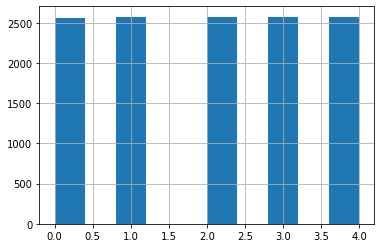

In [ ]:
  data_arr = ['data_n01','data_n02','data_n03','data_n04','data_n06']
  test_data_01 = data_arr[0]
  test_data_02 = data_arr[1]
  test_data_03 = data_arr[2]
  test_data_04 = data_arr[3]
  test_data_05 = data_arr[4]

  #Initialize dataframes for storing the data and combine them 
  test_data1 = pd.read_csv(test_data_01+'.csv')
  test_data2 = pd.read_csv(test_data_02+'.csv')
  test_data3 = pd.read_csv(test_data_03+'.csv')
  test_data4 = pd.read_csv(test_data_04+'.csv')
  test_data5 = pd.read_csv(test_data_05+'.csv')
  test_data_combined = pd.concat([test_data5],ignore_index=True)
  # test_data_combined = pd.concat([test_data1,test_data2,test_data3,test_data4,test_data5],ignore_index=True)
  test_data_combined.Class.hist()

  test_label = test_data_combined.pop("Class")
  test_data_combined = test_data_combined/180

  temp = test_data_combined['x1']
  test_data_combined['x1'] = test_data_combined['y1']*-1
  test_data_combined['y1'] = temp
  temp = test_data_combined['x2']
  test_data_combined['x2']=test_data_combined['y2']
  test_data_combined['y2']=temp

  test_data_combined['x1'] = test_data_combined['x1']-test_data_combined['x3']
  test_data_combined['y1'] = test_data_combined['y1']-test_data_combined['y3']
  test_data_combined['z1'] = test_data_combined['z1']-test_data_combined['z3']
  test_data_combined['x2'] = test_data_combined['x2']-test_data_combined['x3']
  test_data_combined['y2'] = test_data_combined['y2']-test_data_combined['y3']
  test_data_combined['z2'] = test_data_combined['z2']-test_data_combined['z3']
  test_data_combined['x3'] = test_data_combined['x3']-test_data_combined['x4']
  test_data_combined['y3'] = test_data_combined['y3']-test_data_combined['y4']
  test_data_combined['z3'] = test_data_combined['z3']-test_data_combined['z4']
  

In [ ]:
# Loads the weights
model.load_weights("training_0/cp.ckpt")

# Re-evaluate the model
loss, acc = model.evaluate(x_val_test, y_val_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

81/81 - 0s - loss: 0.3308 - accuracy: 0.9179
Restored model, accuracy: 91.79%


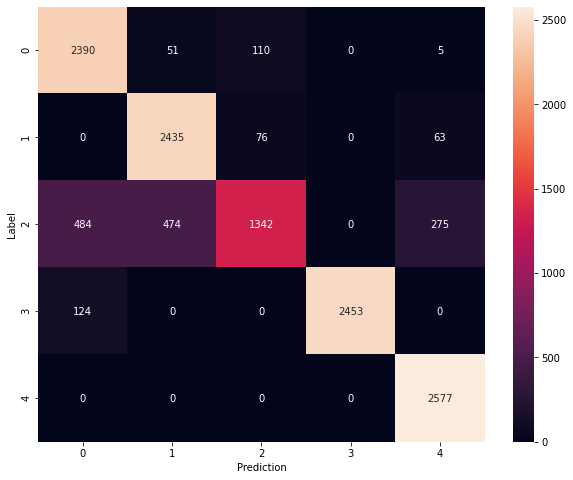

In [ ]:
predictions = model.predict(test_data_combined)
predictions = np.argmax(predictions,axis = 1)
confusion_mtx = tf.math.confusion_matrix(
    test_label, predictions, 5, weights=None, dtype=tf.dtypes.int32,
    name='PCD_Confusion_Matrix'
)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation', name=None, dtype=None,
    thresholds=None, multi_label=False, label_weights=None
)

In [ ]:
predictions = model.predict(test_data_combined)
predictions = softmax(predictions)
predictions 

array([[5.61955154e-01, 3.70681547e-02, 3.90070349e-01, 5.56971827e-06,
        1.09007992e-02],
       [5.72516441e-01, 3.32937948e-02, 3.84544700e-01, 5.71966802e-06,
        9.63940471e-03],
       [5.85002005e-01, 3.02647706e-02, 3.75738829e-01, 5.79662492e-06,
        8.98866821e-03],
       ...,
       [7.22982280e-04, 8.03262577e-04, 4.30756161e-04, 2.49232275e-13,
        9.98043001e-01],
       [7.32297834e-04, 7.77144334e-04, 4.25835256e-04, 2.54759565e-13,
        9.98064756e-01],
       [6.57938595e-04, 8.48602445e-04, 4.24017315e-04, 2.22954101e-13,
        9.98069465e-01]])

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
roc_auc_score(test_label,predictions,average='macro',multi_class ="ovr",labels = None)

0.9863836383723212

In [ ]:
plot_roc("Train Baseline", y_val_test, predictions, color=colors[0])
plt.legend(loc='lower right')

ValueError: ignored

# **CONVERTING THE MODEL**

In [ ]:
#########################################################################################################################################################################
#   Optimize the model for size and convert to tflite model
#########################################################################################################################################################################

#Covert the model to a tflite model & optimize to reduce the size
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

#########################################################################################################################################################################

INFO:tensorflow:Assets written to: /tmp/tmpu4c29gjt/assets


9168

In [ ]:
#########################################################################################################################################################################
#   Function to convert tflite file to C header file
#########################################################################################################################################################################

# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

#########################################################################################################################################################################

In [ ]:
#########################################################################################################################################################################
#   Convert to c-header file via function
#########################################################################################################################################################################

# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))

#########################################################################################################################################################################